# Random Shape Generation
In Part-II, we have trained a GAN model to generate synthetic masses given a tiled image with patches extracted from the mass and healthy tissue around the mask. You may have noticed that in the end of Part-II we only visualised the outputs with the same data as in the training set. This is in general not a good practice. Because we only demonstrated that the generator model is able to memorise and but not generalise to other inputs. Although in other applications this would be considered a ***crime*** (sort of speak), in our project we want to synthesise masses of different shapes, hence, augmenting the training set to include more variaty of shapes.

You may ask, why did we split the dataset into training, validation, and testing sets then? The answer to that is that we want to test the usefulness of the data augmentation in a downstream task of breast mass segmentation. We will follow the following experimental setup as shown in the project presentation slides:

![course_workflow](images/course_workflow.png)


As you can see, we need to create a bank of textures for foreground and background (mass and healthy tissue). Then create shapes using Bezier curves. For the texture bank, we already have the code from the previous part where we extracted small patches of size 32x32 from within masses and outside the masses. We will reuse that function.

The next step is to create a random mask. The random mask should more or less represent real world distribution as shown in the image below.

![mass_shapes](images/mass_shapes.png)

To do this, we will use the Bezier curves! Here is the link to the wikipedia page of the Bezier curve: https://en.wikipedia.org/wiki/B%C3%A9zier_curve. 

Don't spend too much time to read and understand it fully now, it's a resource that you can add to your reading list and check up later on. For now, we will provide you with the implementation.

Your task will be to find some ranges parameters that correspond to the shapes shown above. Namely: **round, oval, lobulated, nodular, stellate,** and **irregular**.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from skimage import draw, morphology
from typing import Tuple, List, Dict, Union, Optional, Callable, Any
from geometry import get_bezier_curve, get_fg_shape



Let's test the get_bezier_curve function to understand the bezier curve parameters. This function has the following signature:
`get_bezier_curve(a, rad=0.2, edgy=0)`, which creates a curve through given an array of points `a`.
```
    *rad* is a number between 0 and 1 to steer the distance of
          control points.
    *edgy* is a parameter which controls how "edgy" the curve is,
           edgy=0 is smoothest.
```

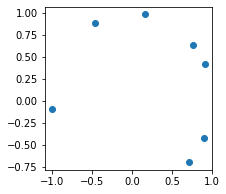

In [2]:
# First, we need the function to get the points on a circle
def get_random_points_on_circle(
    n: int, scale: float, radius: float = 1.0, center: Tuple[float, float] = (0.0, 0.0)
) -> np.ndarray:
    """Get some random points on a circle.

    Args:
        n_points (int): Number of points.
        radius (float): Radius of the circle.
        center (Tuple[float, float]): Center of the circle.

    Returns:
        np.ndarray: Array of shape (n_points, 2) containing the points.
    """
    angles = np.random.uniform(0, 2 * np.pi, n)
    x = radius * np.cos(angles) + center[0]
    y = radius * np.sin(angles) + center[1]
    return np.stack([x, y], axis=-1) * scale

points = get_random_points_on_circle(7, 1)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(points[:, 0], points[:, 1])
plt.show()

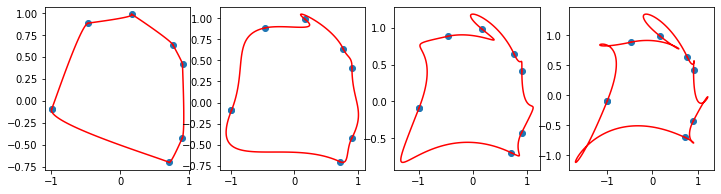

In [3]:
# Let's call the get_bezier_curve function with the points we just generated with different values of rad
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i, rad in enumerate([0.1, 0.5, 1.0, 1.5]):
    x, y, curve, segments = get_bezier_curve(points, rad=rad, edgy=100)
    ax[i].scatter(curve[:, 0], curve[:, 1])
    for segment in segments:
        ax[i].plot(segment.curve[:, 0], segment.curve[:, 1], "r")
plt.show()

As you can see, we only changed the `rad` parameter with `edgy` being a constant. For 7 random points around a circle, you should see something like this:
![curves](images/bezier_curves.png)

Overall, there are three parameters to play with:

- `rad`: how affects the *wigglyness* of the curve connecting two points.
- `edgy`: affects how sharp or extreme this wigglyness is.
- `point_distribution`: this is the function `get_random_points_on_circle`. These points are static between the curves, so we need to control the randomness of the points. This can be defined in many different ways. For example, we can come up with these two parameters:
  - `number_of_points` is one parameter
  - `min_distance` to define the minimum distance between the points so two points are not closer to each other than this value.

### Parameter definition
**TASK 1** You task is to find range of parameters that define each of the shape types described above. Fill in the dictionary below with your findings.

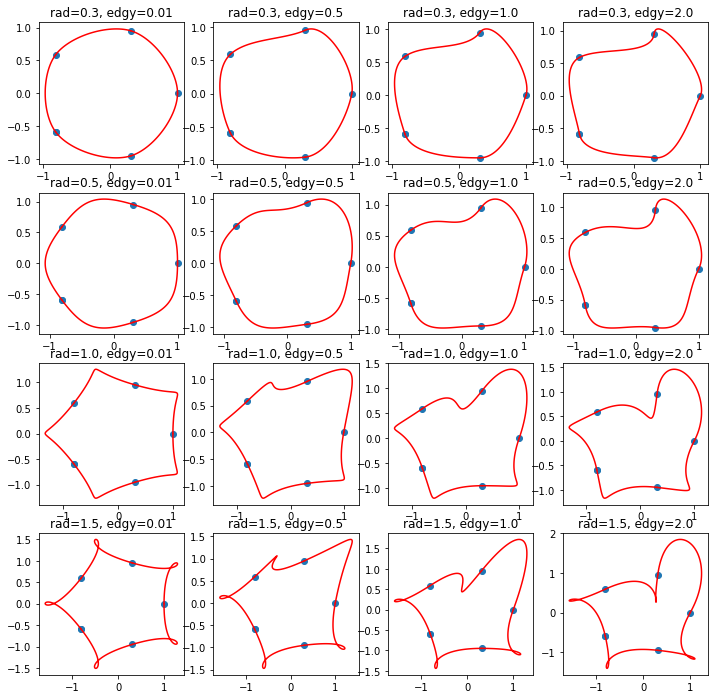

In [24]:
# TASK 1:
# Try to find the best value of rad for each type of shape
# Then fill in the dictionary in the next code cell block with the values of:
# rad, edge, number of points, point distribution fuction that you think are best for each type of shape
# HINT: Not all shapes can be achieved with the same point distribution that is returnd by get_random_points_on_circle function!!!
# You must create different functions to get the points for different shapes
# For example, this function will return points evenly distributed on a circle
def get_even_points_on_circle(
    n: int, scale: float, radius: float = 1.0, center: Tuple[float, float] = (0.0, 0.0)
) -> np.ndarray:
    """Get some random points on a circle that are evenly distributed.
    Args:
        n_points (int): Number of points.
        radius (float): Radius of the circle.
        center (Tuple[float, float]): Center of the circle.
    Returns:
        np.ndarray: Array of shape (n_points, 2) containing the points.
    """
    # NOTE Notice the difference between this function and get_random_points_on_circle function?
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x = radius * np.cos(angles) + center[0]
    y = radius * np.sin(angles) + center[1]
    return np.stack([x, y], axis=-1) * scale

# This is the same code as in the previous cell. Try to change the value of rad and edge in the loop to see how it affects the shapes
# Don't forget to record the range of values that best work for each shape!
# points = get_random_points_on_circle(5, 1)  # This gives a random distribution of points around a circle (not evenly distributed)
points = get_even_points_on_circle(5, 1)  # <--- Try changing the number of points to see how it affects the shape (TODO)
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i, rad in enumerate([0.3, 0.5, 1.0, 1.5]):  # <--- Try different values of rad (TODO)
    for j, edgy in enumerate([0.01, 0.5, 1.0, 2.0]):  # <--- Try different values of edge (TODO)
        x, y, curve, segments = get_bezier_curve(points, rad=rad, edgy=edgy)
        ax[i][j].scatter(curve[:, 0], curve[:, 1])
        for segment in segments:
            ax[i][j].plot(segment.curve[:, 0], segment.curve[:, 1], "r")
            ax[i][j].set_title(f"rad={rad}, edgy={edgy}")
plt.show()
# NOTE to remember: record the values

In [5]:
params = {
    'round': {
        'rad': [],
        'edgy': None,
        'n': [],
        'scale': [],
        'func': None,
    },
    'oval': {
        'rad': [0.3, 0.51],  # range for rad that returns an oval curve
        'edgy': 0.01,  # edgy value for the curve to be oval
        'n': [3, 4],  # range of min and max number of points on the circle
        'scale': [40, 41], # range of min and max scale (OPTIONAL for now)
        'func': get_random_points_on_circle,  # function to get the points on the circle
    },
    'lobulated': {
        'rad': [],
        'edgy': None,
        'n': [],
        'scale': [],
        'func': None,
    },
    'nodular': {
        'rad': [],
        'edgy': None,
        'n': [],
        'scale': [],
        'func': None,
    },
    'stellate': {
        'rad': [],
        'edgy': None,
        'n': [],
        'scale': [],
        'func': None,
    },
    'irregular': {
        'rad': [],
        'edgy': None,
        'n': [],
        'scale': [],
        'func': None,
    }
}

Let's see you if you got them! change the `['oval']` to the complete list of shapes and run it. You should see 10 examples of different shape masks.

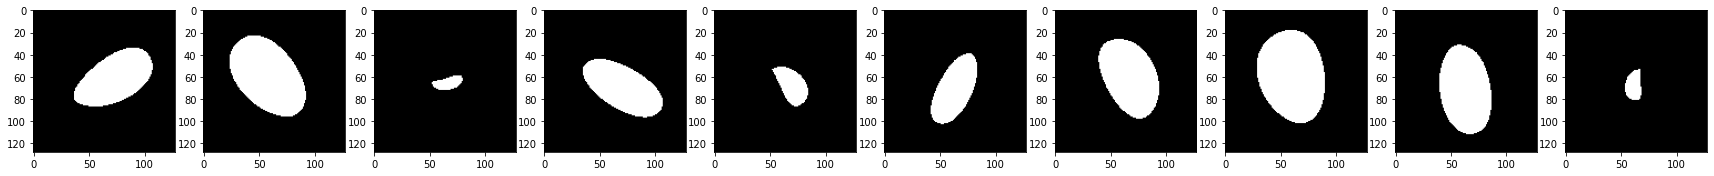

In [25]:
for shape in ['oval']:  # ['round', 'oval', 'lobulated', 'nodular', 'stellate', 'irregular']:
    # repeat 10 times to see the variation in the shape
    fig, ax = plt.subplots(1, 10, figsize=(30, 3))
    for i in range(10):
        n = np.random.randint(*params[shape]['n'])
        rad = np.random.uniform(*params[shape]['rad'])
        edgy = params[shape]['edgy']
        scale = np.random.uniform(*params[shape]['scale'])
        func = params[shape]['func']

        img = get_fg_shape(params=params, h=128, w=128, shape=shape)
        ax[i].imshow(img, cmap='gray')
    plt.show()

### Tiling (again)

Since we can generate any shape we want and we can extract small patches from our training images. We already have done the second part in the previous part. To recap, we followed these steps:

1. Get the image and the corresponding mask
2. Extract two small patches, one from the inside and one from the outside of the mask randomly selected (representing mass texture and background texture). Let's call them `fg-patch` and `bg-patch`.
3. Create a new tiled image so that the `fg-patch` is only inside the mask and `bg-patch` is only outside the mask.

Before, for the step 3, we used the original mask. Now, we will use the synthetic shapes to do this.